## Comparison of Kerr [a=0] and Schwarzschild metrics implementation

In [1]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"

output_directory = project_path * "data/output/case_1/kerr/";

In [2]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load
# gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

  Activating project at `~/Escritorio/TFM/code/01_project`


In [3]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "kan/"
model_name = "kan/" #"encoder/" #

output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/"
list_directories = (output_dir, solutions_dir, metrics_dir, img_dir)
create_directories(list_directories)

In [10]:
# Define neural network model
NN, NN_params, chain, re = nn_model_case1_arch1_modified(32, tanh);



datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters

χ₀ = Float64(pi + 0.0001); 
ϕ₀ = Float64(0.0); 
p_space = Float64.([100])
M=Float64(1.0); 
e_space = Float64.([0.5])
tspan_train = (0, 6.0f4)

println("Train dataset creation")
train_info = [];
for e in e_space 
    for p in p_space
        train_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_train, datasize, dt);
        true_info = get_true_solution_EMR_schwarzschild(train_info_i["u0"], train_info_i["model_params"], mass_ratio, M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
        push!(train_info, merge(train_info_i, true_info))
    end
end

# TEST waveform parameters

ϕ₀ = Float64(0.0); 
p=Float64(100.0); 
M=Float64(1.0);
e_space = Float64.([0.5])
tspan_test = (tspan_train[1], tspan_train[2])
a=1e-5


println("Test dataset creation")
test_info = [];
for e in e_space
    test_info_i = get_pinn_EMR_kerr(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_test, datasize, dt);
    true_info = get_true_solution_EMR_kerr(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
    push!(test_info, merge(test_info_i, true_info))
end


# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);


Initializating weights as zero.
Train dataset creation
Test dataset creation
Processing datasets
Creating test dataset 
Creating train dataset 


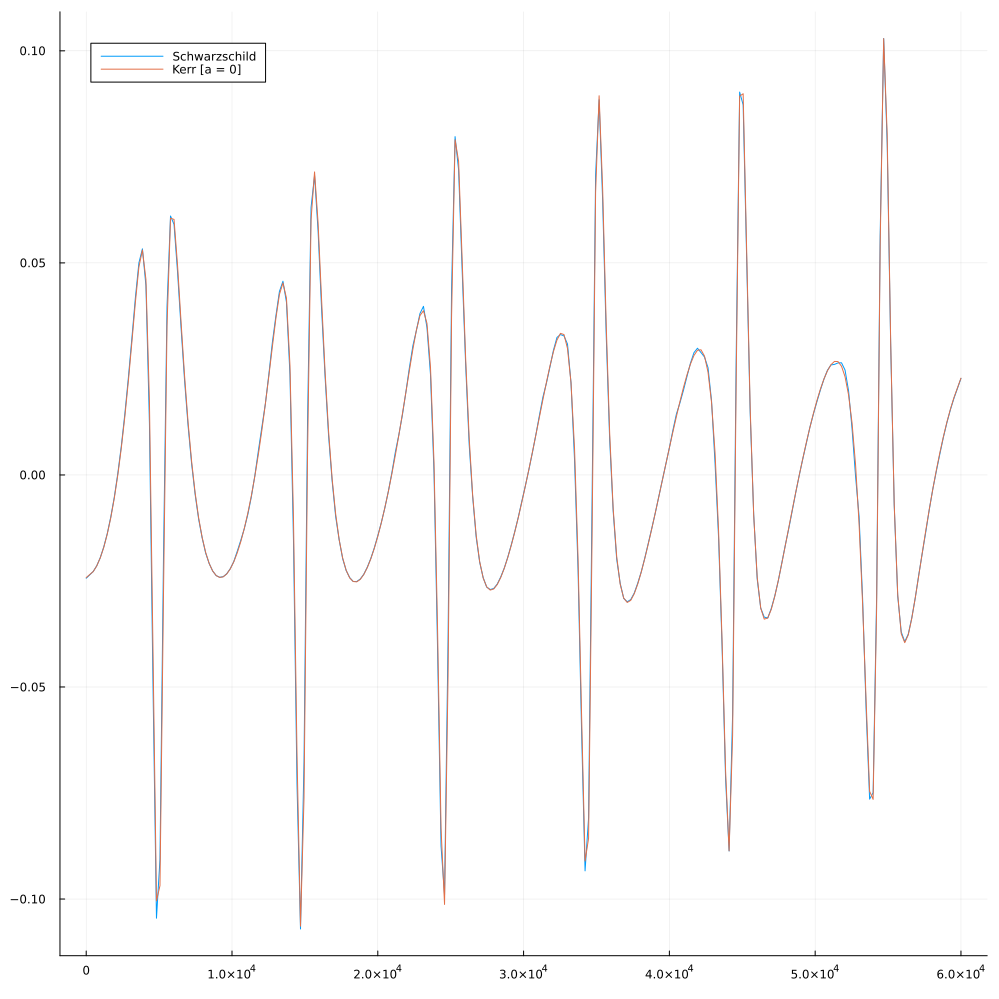

In [11]:
plot(
    processed_data["train"][1]["tsteps"],
    processed_data["train"][1]["true_waveform"],
    label="Schwarzschild",
    size=(1000,1000)
)

plot!(
    processed_data["test"][1]["tsteps"],
    processed_data["test"][1]["true_waveform"],
    label="Kerr [a = 0]"
)